In [4]:
#Machine Learning Trading Stratergy
# Dennis, Eilon, Ivan
# Final Project - Data Bootcamp
!pip install mplfinance

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import mplfinance as mpf

import yfinance as yf
import requests
from datetime import datetime, timedelta
import json
import warnings
from io import StringIO
from IPython.display import display, HTML

warnings.filterwarnings("ignore")

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, auc, confusion_matrix, ConfusionMatrixDisplay)

In [5]:
#OLD FUNCTIONS FROM MIDTERM SLIGHTLY EDITED FOR ML

#define rolling historical window for data retreival
def get_date_range(days=780):
    end = datetime.now()
    start = end - timedelta(days=days)

    return start, end

def fetch_data(symbol, start_date, end_date, interval='1d', auto_adjust=True):
    #download
    df = yf.download(symbol, start=start_date, end=end_date, interval=interval, auto_adjust=auto_adjust, progress=False)

    #flatten multiindex columns if present
    if isinstance(df.columns, pd.MultiIndex):
        df.columns = df.columns.get_level_values(0)

    #keep standard ohlcv feilds
    required = ["Open", "High", "Low", "Close", "Volume"]
    df = df[required]

    #clean datetime index and drop missing rows
    df.index = df.index.tz_localize(None)
    df = df.dropna()

    return df

def indicators(df):
    #exponential ma's
    df['EMA9'] = df['Close'].ewm(span=9, adjust=False).mean()
    df['EMA21'] = df['Close'].ewm(span=21, adjust=False).mean()

    #simple ma's
    df['MA50'] = df['Close'].rolling(window=50, min_periods=1).mean()
    df['MA200'] = df['Close'].rolling(window=200, min_periods=1).mean()

    return df

def load_QQQ_tickers():
    #scrape nasdaq100 tickers from wikipedia
    html = requests.get("https://en.wikipedia.org/wiki/Nasdaq-100", headers={"User-Agent": "Mozilla/5.0"}, timeout=10).text

    df = pd.read_html(StringIO(html), match="Ticker")[0]

    #normalize ticker symbols for yfinance compatibility
    df["Ticker"] = df["Ticker"].astype(str).str.strip().str.replace(".", "-", regex=False)

    tickers = df["Ticker"].tolist()

    print(f"Loaded {len(tickers)} Nasdaq-100 tickers.")

    return tickers, df

class PortfolioTracker:
    def __init__(self, starting_cash=100000):
        #track available cash, open positions, and trade history
        self.cash = round(starting_cash, 2)
        self.positions = {}   #{ticker: {"qty": int, "avg_price": float}}
        self.history = []     #executed trades

    def buy(self, symbol, qty, price):
        #execute buy if sufficient cash available
        cost = round(qty * price, 2)
        if cost > self.cash:
            return False

        self.cash = round(self.cash - cost, 2)

        if symbol in self.positions:
            pos = self.positions[symbol]
            new_qty = pos["qty"] + qty
            pos["avg_price"] = (
                (pos["avg_price"] * pos["qty"] + price * qty) / new_qty
            )
            pos["qty"] = new_qty
        else:
            self.positions[symbol] = {"qty": qty, "avg_price": price}

        self.history.append({
            "action": "BUY",
            "symbol": symbol,
            "qty": qty,
            "price": price
        })
        return True

    def sell(self, symbol, qty, price):
        #sell up to available quantity
        if symbol not in self.positions:
            return False

        pos = self.positions[symbol]
        qty = min(qty, pos["qty"])
        proceeds = round(qty * price, 2)

        self.cash = round(self.cash + proceeds, 2)
        pos["qty"] -= qty

        if pos["qty"] == 0:
            del self.positions[symbol]

        self.history.append({
            "action": "SELL",
            "symbol": symbol,
            "qty": qty,
            "price": price
        })
        return True

    def total_value(self, price_lookup=None):
        #compute total portfolio value using latest prices when available
        value = self.cash
        for symbol, pos in self.positions.items():
            px = price_lookup.get(symbol, pos["avg_price"]) if price_lookup else pos["avg_price"]
            value += pos["qty"] * px
        return round(value, 2)

    def summary(self):
        print("\nPortfolio Summary:")
        print("Cash:", self.cash)
        print("Positions:", self.positions)
        print("Total value:", self.total_value())

In [6]:
#Feature Engineering + Dataset Creation

tickers, _ = load_QQQ_tickers()
print(f"Processing {len(tickers)} tickers...\n")

dfs = []

def build_features(df):
    #returns
    df["return_1d_raw"] = df["Close"].pct_change()
    df["return_5d"] = df["Close"].pct_change(5)

    #rolling volatility
    df["vol_5d"] = df["return_1d_raw"].rolling(5).std()
    df["vol_20d"] = df["return_1d_raw"].rolling(20).std()

    #ema-based features
    df["ema_diff"] = df["EMA9"] - df["EMA21"]
    df["price_ema_diff"] = df["Close"] - df["EMA21"]

    #volume dynamics
    df["volume_change"] = df["Volume"].pct_change()

    return df

def process_one_ticker(t):
    #fetch historical price data
    start, end = get_date_range()
    df = fetch_data(t, start, end)

    if df is None or df.empty:
        return None

    #compute indicators and engineered features
    df = indicators(df)
    df = build_features(df)

    #binary next-day return target
    df["return_1d"] = df["Close"].pct_change().shift(-1)
    df["target_up"] = (df["return_1d"] > 0).astype(int)

    #drop final row with undefined target
    df = df.dropna(subset=["return_1d"])

    #attach ticker identifier
    df["ticker"] = t

    return df


#build dataset across all tickers
for t in tickers:
    print("Processing:", t)
    df = process_one_ticker(t)
    if df is not None and not df.empty:
        dfs.append(df)


#combine all tickers into a single modeling dataset
data = pd.concat(dfs)
data["Date"] = data.index
data = data.reset_index(drop=True)
data = data.dropna()

#ensure proper temporal ordering within each ticker
data = data.sort_values(["ticker", "Date"]).reset_index(drop=True)
assert data.groupby("ticker")["Date"].apply(lambda x: x.is_monotonic_increasing).all()

print("\nFinal dataset shape:", data.shape)
print("Columns:", data.columns.tolist())

Loaded 101 Nasdaq-100 tickers.
Processing 101 tickers...

Processing: ADBE
Processing: AMD
Processing: ABNB
Processing: GOOGL
Processing: GOOG
Processing: AMZN
Processing: AEP
Processing: AMGN
Processing: ADI
Processing: AAPL
Processing: AMAT
Processing: APP
Processing: ARM
Processing: ASML
Processing: AZN
Processing: TEAM
Processing: ADSK
Processing: ADP
Processing: AXON
Processing: BKR
Processing: BIIB
Processing: BKNG
Processing: AVGO
Processing: CDNS
Processing: CDW
Processing: CHTR
Processing: CTAS
Processing: CSCO
Processing: CCEP
Processing: CTSH
Processing: CMCSA
Processing: CEG
Processing: CPRT
Processing: CSGP
Processing: COST
Processing: CRWD
Processing: CSX
Processing: DDOG
Processing: DXCM
Processing: FANG
Processing: DASH
Processing: EA
Processing: EXC
Processing: FAST
Processing: FTNT
Processing: GEHC
Processing: GILD
Processing: GFS
Processing: HON
Processing: IDXX
Processing: INTC
Processing: INTU
Processing: ISRG
Processing: KDP
Processing: KLAC
Processing: KHC
Proces

In [7]:
#ML Models

#feature selection
feature_cols = ['EMA9', 'EMA21', 'MA50', 'MA200','return_5d','vol_5d', 'vol_20d','ema_diff', 'price_ema_diff','volume_change',]

#prepare modeling dataset
ml_data = data.dropna(subset=feature_cols + ['target_up'])
ml_data = ml_data.sort_values(["ticker", "Date"]).reset_index(drop=True)

X = ml_data[feature_cols]
y = ml_data['target_up']

#time aware train/test split
split_idx = int(len(ml_data) * 0.8)

train = ml_data.iloc[:split_idx]
test = ml_data.iloc[split_idx:]

X_train = train[feature_cols]
y_train = train["target_up"]

X_test = test[feature_cols]
y_test = test["target_up"]

#scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [8]:
#Train ML Models + Evaluate Performance

results = []

def evaluate_model(model, model_name):
    model.fit(X_train_scaled, y_train)

    preds = model.predict(X_test_scaled)

    acc = accuracy_score(y_test, preds)
    prec = precision_score(y_test, preds)
    rec = recall_score(y_test, preds)
    f1 = f1_score(y_test, preds)

    if hasattr(model, "predict_proba"):
        probs = model.predict_proba(X_test_scaled)[:, 1]
        roc = roc_auc_score(y_test, probs)
    else:
        roc = np.nan

    results.append((model_name, acc, prec, rec, f1, roc))


#baseline: always predict up
baseline_preds = np.ones(len(y_test))

results.append(("Baseline (Always Up)", accuracy_score(y_test, baseline_preds), precision_score(y_test, baseline_preds), recall_score(y_test, baseline_preds), f1_score(y_test, baseline_preds), np.nan))

#logistic regression
log_reg = LogisticRegression(max_iter=2000, n_jobs=-1, class_weight="balanced")
evaluate_model(log_reg, "Logistic Regression")

#random forest
rf = RandomForestClassifier(n_estimators=300, max_depth=None, min_samples_split=2, n_jobs=-1, random_state=42)
evaluate_model(rf, "Random Forest")

#gradient boosting
gb = GradientBoostingClassifier(n_estimators=200, learning_rate=0.05, max_depth=3, random_state=42)
evaluate_model(gb, "Gradient Boosting")

#summary table
summary_df = pd.DataFrame(results, columns=["Model", "Accuracy", "Precision", "Recall", "F1", "ROC-AUC"])

print("MODEL COMPARISON TABLE")
summary_df

MODEL COMPARISON TABLE


,Model,Accuracy,Precision,Recall,F1,ROC-AUC
0,Baseline (Always Up),0.524327,0.524327,1.000000,0.687945,NaN
1,Logistic Regression,0.509038,0.531574,0.535668,0.533613,0.511023
2,Random Forest,0.507500,0.526349,0.606272,0.563491,0.505767
3,Gradient Boosting,0.520673,0.524164,0.930864,0.670675,0.509138


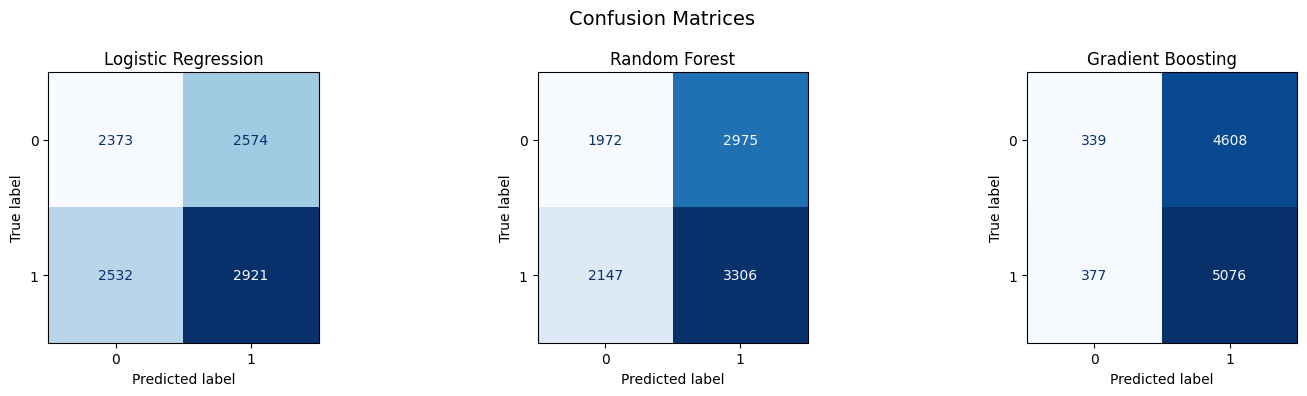

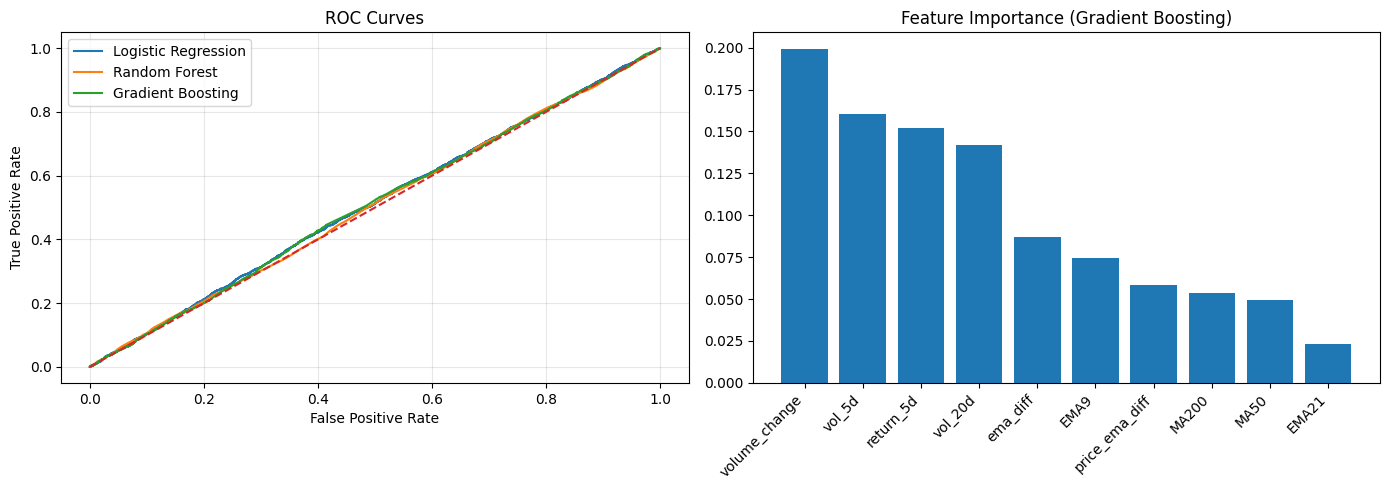

In [9]:
#Visualization
models = {"Logistic Regression": log_reg, "Random Forest": rf, "Gradient Boosting": gb}

#confusion matrices (side by side)
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

for ax, (name, model) in zip(axes, models.items()):
    preds = model.predict(X_test_scaled)
    ConfusionMatrixDisplay.from_predictions(y_test, preds, cmap="Blues", ax=ax, colorbar=False)
    ax.set_title(name)

fig.suptitle("Confusion Matrices", fontsize=14)
plt.tight_layout()
plt.show()

#roc curves + feature importance (side by side)
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

#roc curves
for name, model in models.items():
    if hasattr(model, "predict_proba"):
        probs = model.predict_proba(X_test_scaled)[:, 1]
        fpr, tpr, _ = roc_curve(y_test, probs)
        axes[0].plot(fpr, tpr, label=name)

axes[0].plot([0, 1], [0, 1], linestyle="--")
axes[0].set_title("ROC Curves")
axes[0].set_xlabel("False Positive Rate")
axes[0].set_ylabel("True Positive Rate")
axes[0].legend()
axes[0].grid(alpha=0.3)

#feature importance (gradient boosting)
importances = gb.feature_importances_
idx = np.argsort(importances)[::-1]

axes[1].bar(range(len(importances)), importances[idx])
axes[1].set_xticks(range(len(importances)))
axes[1].set_xticklabels(np.array(feature_cols)[idx], rotation=45, ha="right")
axes[1].set_title("Feature Importance (Gradient Boosting)")

plt.tight_layout()
plt.show()

Automatically selected model: Gradient Boosting
Deploying final strategy with threshold = 0.55

Portfolio Summary:
Cash: 74014.1
Positions: {'TXN': {'qty': 629, 'avg_price': 170.6478729248047}, 'PYPL': {'qty': 16, 'avg_price': 72.8515853881836}, 'ROP': {'qty': 2, 'avg_price': 456.1600036621094}, 'ROST': {'qty': 7, 'avg_price': 160.33474731445312}, 'XEL': {'qty': 4, 'avg_price': 81.1099967956543}, 'TTD': {'qty': 3, 'avg_price': 41.869998931884766}}
Total value: 185001.95


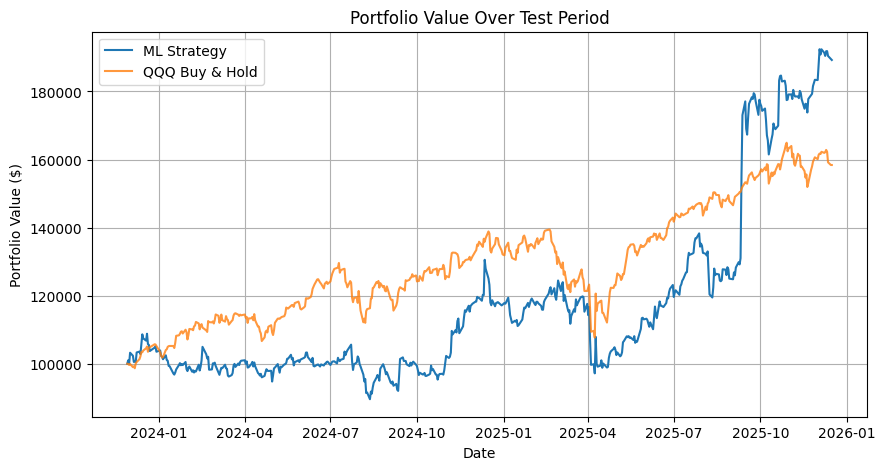

Final Strategy Value: 189249.82
Final QQQ Value: 158395.92


RISK-ADJUSTED PERFORMANCE
ML Strategy  | Sharpe: 1.14 | Max DD: -25.56%
QQQ BuyHold | Sharpe: 1.19 | Max DD: -22.77%


In [10]:
#Trading Simulation + Evaluation

#automatic model selection
best_model_name = (summary_df.query("Model != 'Baseline (Always Up)'").sort_values(["Recall", "F1", "ROC-AUC"], ascending=False).iloc[0]["Model"])
model_lookup = {"Logistic Regression": log_reg, "Random Forest": rf, "Gradient Boosting": gb}
best_model = model_lookup[best_model_name]

print("Automatically selected model:", best_model_name)

#confidence-weighted trading function
def run_strategy_confidence_weighted(df, starting_cash=100000, max_exposure=0.6):
    portfolio = PortfolioTracker(starting_cash=starting_cash)
    history = []

    #ensure proper ordering
    df = df.sort_values(["Date", "ticker"]).reset_index(drop=True)

    for date, day_df in df.groupby("Date"):
        #execute sells
        for _, row in day_df[day_df["signal"] == -1].iterrows():
            sym = row["ticker"]
            if sym in portfolio.positions:
                qty = portfolio.positions[sym]["qty"]
                portfolio.sell(sym, qty, row["Close"])

        #execute buys
        buys = day_df[day_df["signal"] == 1]
        if not buys.empty:
            total_value = portfolio.total_value()
            target_value = total_value * max_exposure
            invested = total_value - portfolio.cash
            remaining = max(target_value - invested, 0)

            conf_sum = buys["prob_up"].sum()
            if conf_sum > 0 and remaining > 0:
                for _, row in buys.iterrows():
                    alloc = remaining * (row["prob_up"] / conf_sum)
                    price = row["Close"]
                    qty = int(alloc // price)
                    if qty > 0:
                        portfolio.buy(row["ticker"], qty, price)

        #compare to market daily
        px = dict(zip(day_df["ticker"], day_df["Close"]))
        history.append({"Date": date, "TotalValue": portfolio.total_value(price_lookup=px)})

        portfolio.cash = round(portfolio.cash, 2)

    return portfolio, pd.DataFrame(history)

#generate trading signals
FINAL_THRESHOLD = 0.55
print(f"Deploying final strategy with threshold = {FINAL_THRESHOLD}")

trade_df = data.loc[X_test.index].copy()
trade_df["prob_up"] = best_model.predict_proba(X_test_scaled)[:, 1]

trade_df["signal"] = 0
trade_df.loc[trade_df["prob_up"] > FINAL_THRESHOLD, "signal"] = 1
trade_df.loc[trade_df["prob_up"] < 1 - FINAL_THRESHOLD, "signal"] = -1

#run  portfolio
portfolio, equity_curve = run_strategy_confidence_weighted(trade_df, starting_cash=100000, max_exposure=0.6)
portfolio.summary()

#strategy vs benchmark
qqq = fetch_data("QQQ", trade_df["Date"].min(), trade_df["Date"].max())

qqq = qqq.reindex(equity_curve["Date"]).ffill()
qqq_equity = 100000 * (1 + qqq["Close"].pct_change().fillna(0)).cumprod()

plt.figure(figsize=(10, 5))
plt.plot(equity_curve["Date"], equity_curve["TotalValue"], label="ML Strategy")
plt.plot(equity_curve["Date"], qqq_equity.values, label="QQQ Buy & Hold", alpha=0.8)
plt.title("Portfolio Value Over Test Period")
plt.xlabel("Date")
plt.ylabel("Portfolio Value ($)")
plt.legend()
plt.grid(True)
plt.show()

print("Final Strategy Value:", round(equity_curve["TotalValue"].iloc[-1], 2))
print("Final QQQ Value:", round(qqq_equity.iloc[-1], 2))

#open Positions

last_px = (trade_df.sort_values("Date") .groupby("ticker") .tail(1) .set_index("ticker")["Close"])

open_df = pd.DataFrame([{"Ticker": t, "Qty": p["qty"], "Avg": p["avg_price"], "Px": last_px.get(t, p["avg_price"])} for t, p in portfolio.positions.items()])

open_df["Value"] = open_df["Qty"] * open_df["Px"]
open_df["PnL $"] = open_df["Qty"] * (open_df["Px"] - open_df["Avg"])
open_df["PnL %"] = 100 * open_df["PnL $"] / (open_df["Qty"] * open_df["Avg"])

open_df = open_df.round(2).sort_values("PnL $", ascending=False)

#realized trades
trades = pd.DataFrame(portfolio.history)

realized_df = (trades.pivot_table(index="symbol", columns="action", values=["qty", "price"], aggfunc="mean"))
realized_df.columns = realized_df.columns.map("_".join)
realized_df["PnL $"] = (realized_df["qty_SELL"] *(realized_df["price_SELL"] - realized_df["price_BUY"]))
realized_df["PnL %"] = (100 * realized_df["PnL $"] /(realized_df["qty_SELL"] * realized_df["price_BUY"]))
realized_df = (realized_df.dropna().reset_index().rename(columns={"symbol": "Ticker"}).round(2).sort_values("PnL $", ascending=False))

display(HTML(
    "<div style='display:flex;gap:40px'>"
    "<div><h3>Open Positions</h3>"
    + open_df.to_html(index=False) +
    "</div>"
    "<div><h3>Realized Winners / Losers</h3>"
    + realized_df[['Ticker','qty_SELL','price_BUY','price_SELL','PnL $','PnL %']].to_html(index=False) +
    "</div>"
    "</div>"))

#risk adjusted performance
def sharpe_and_drawdown(returns, equity):
    sharpe = (returns.mean() / returns.std()) * np.sqrt(252)
    drawdown = (equity / equity.cummax() - 1).min()
    return round(sharpe, 2), round(drawdown * 100, 2)

strategy_returns = equity_curve["TotalValue"].pct_change().dropna()
qqq_returns = qqq_equity.pct_change().dropna()

s_sharpe, s_dd = sharpe_and_drawdown(strategy_returns, equity_curve["TotalValue"])
q_sharpe, q_dd = sharpe_and_drawdown(qqq_returns, qqq_equity)

print("RISK-ADJUSTED PERFORMANCE")
print(f"ML Strategy  | Sharpe: {s_sharpe} | Max DD: {s_dd}%")
print(f"QQQ BuyHold | Sharpe: {q_sharpe} | Max DD: {q_dd}%")